In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import os, subprocess, pickle
import astropy.units as u
import healpy as hp
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
from scipy.stats import norm
from scipy.optimize import curve_fit, root_scalar
from scipy.ndimage import gaussian_filter

from gammapy.irf import load_irf_dict_from_file
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.data import DataStore, Observation, FixedPointingInfo
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, RingBackgroundMaker
from gammapy.datasets import Datasets, MapDataset, MapDatasetOnOff
from gammapy.estimators import ExcessMapEstimator
from gammapy.stats.fit_statistics import cash
from gammapy.estimators.map.excess import convolved_map_dataset_counts_statistics
from gammapy.modeling.models import PointSpatialModel, PowerLawSpectralModel, SkyModel, Models

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, append=True)
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import ligo.skymap.plot
from ligo.skymap.io.fits import read_sky_map
import utils

observing_location = EarthLocation.of_site("Roque de los Muchachos")

# Creating the needed folders needed
for directory in [
    "./data/", "./data/tmp/", "./data/gw_input/", "./data/results/", "./data/slurm_output/"
]:
    os.makedirs(directory) if not os.path.exists(directory) else None
        
    
from gammapy import __version__ as gammapy_version
print(f"Using Gammapy version: {gammapy_version}")

Using Gammapy version: 1.1


##### <span style="color:blue">Main parameters</span>

In [2]:
# source_name = "S240615dg"

# dir_dl3 = os.path.join(
#     "/fefs/aswg/workspace/juan.jimenez/data/real", "mono", source_name, "v0.10.20", 
#     "GammaDiffuse", "prod_standard", "DL3", "gh_dyn50"
# )

# source_coord = SkyCoord(ra=7.53, dec=45.81, unit="deg")

# e_min, e_max, e_bins = 0.15 * u.TeV, 0.6 * u.TeV, 4.5
# # e_min, e_max, e_bins = 0.6 * u.TeV, 20 * u.TeV, 4.5

# obs_ids = [17822, 17823, 17824, 17825]

# bkg_type = "pybkgmodel" # baccmod or pybkgmodel

In [2]:
source_name = "S240615dg"

dir_dl3 = os.path.join(
    "/fefs/aswg/workspace/juan.jimenez/data/real", "stereo", source_name, "v0.5.4", 
    "GammaDiffuse", "prod_standard", "DL3", "gh_dyn70"
)

source_coord = SkyCoord(ra=7.53, dec=45.81, unit="deg")

e_min, e_max, e_bins = 0.4 * u.TeV, 0.8 * u.TeV, 4.5

obs_ids = [17821, 17822, 17823, 17824, 17825]


bkg_type = "pybkgmodel" # baccmod or pybkgmodel

Other parameters

In [3]:
# --- Binning --- #
o_min, o_max, o_bins = 0 * u.deg, 2.5 * u.deg, 5 # Offset binning

size_fov = 2.5 * u.deg

ring_r_in, ring_width = 0.35 * u.deg, 0.2 * u.deg

### <span style="color:blue">Reading GW data</span>

In [4]:
file_ligo = f"./data/gw_input/{source_name}.fits"

# Other parameters that can be changed but no need in principle
resolution_hp_to_grid = 2048 # Resolution of the HEALPix map to be used
threshold_percent_gw = np.flip(np.sort([0.95, 0.5])) # % of probabilities contours

ra_bins  = np.linspace(-180, 180, resolution_hp_to_grid)
dec_bins = np.linspace(-90, 90, resolution_hp_to_grid)
ra_grid, dec_grid = np.deg2rad(np.meshgrid(ra_bins, dec_bins))

data_ligo_hp, meta_ligo_hp = read_sky_map(file_ligo)
data_ligo_2d = utils.healpix2map(data_ligo_hp, ra_bins, dec_bins)
data_ligo_2d_smooth = gaussian_filter(data_ligo_2d, sigma=2)

# Getting the thresholds for probability containment
threshold_maps = utils.get_hp_map_thresholds(data_ligo_hp, threshold_percent_gw)

# Getting the coordinate of hottest spot
hotspot_coord = utils.get_2d_map_hotspot(data_ligo_2d, ra_bins, dec_bins)

### Defining the geometry (FoV, Energy axis, Spatial Binning)

Reco Energy axis edges:


<Quantity [0.4       , 0.56568542, 0.8       ] TeV>

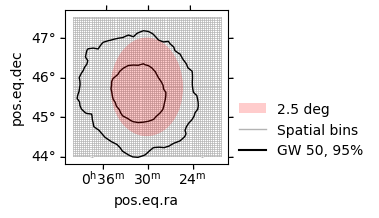

In [5]:
# Defining offset axis
axis_offset = MapAxis.from_bounds(o_min, o_max, nbin=o_bins, name="offset")
# Defining energy axis
axis_energy = MapAxis.from_energy_bounds(
    e_min, e_max, nbin=e_bins, per_decade=True, name="energy"
); print(f"Reco Energy axis edges:"); display(axis_energy.edges)

geom_width = size_fov.value * 1.43, size_fov.value * 1.43
width, binsz = (geom_width), 0.05
npix = (int(width[0]/binsz), int(width[1]/binsz))

geom = WcsGeom.create(
    skydir = (source_coord.ra.degree, source_coord.dec.degree), 
    npix = npix, binsz = binsz, width = width, frame = "icrs",
    proj = "AIR", axes = [axis_energy],
)
geom_image = geom.to_image()

geom_centers = geom.get_coord(mode="center")
geom_edges = geom.get_coord(mode="edges")
bin_c_ra, bin_c_dec = geom_centers.lon[0].value, geom_centers.lat[0].value
bin_edges_ra, bin_edges_dec = geom_edges.lon[0].value, geom_edges.lat[0].value
bin_area = geom_image.solid_angle()

coord_array = SkyCoord(bin_c_ra, bin_c_dec, unit=u.deg)
separations_map = coord_array.separation(SkyCoord(*geom.center_coord)).deg

# Plotting geometry summary
utils.summary_geometry(geom, bin_edges_ra, bin_edges_dec, size_fov, data_ligo_2d, threshold_maps)

### <span style="color:blue">Converting the GW information into the WCS geometry</span>

In [6]:
pix_indices, nside = np.arange(len(data_ligo_hp)), hp.npix2nside(len(data_ligo_hp))
dec_hp, ra_hp = utils.IndexToDeclRa(pix_indices, nside)
hp_area = hp.nside2pixarea(nside)

# Reducing HealPix map to approx the WCS region
mask_hp_wcs = (
    (-(((ra_hp + 180) % 360) - 180) >= bin_edges_ra[:,-1:].min()) & (dec_hp >= bin_edges_dec[:1,:].max()) &
    (-(((ra_hp + 180) % 360) - 180) <= bin_edges_ra[:,:1].min()) & (dec_hp <= bin_edges_dec[-1:,:].max())
)
data_ligo_hp_wcs = data_ligo_hp[mask_hp_wcs]
dec_hp_wcs, ra_hp_wcs = dec_hp[mask_hp_wcs], -(ra_hp[mask_hp_wcs] + 180) % 360 - 180

# Now we integrate the probability for every bin in WCS
prob_gw_integrated = np.zeros((len(bin_edges_ra)-1, len(bin_edges_dec)-1))
num_hp_pixels = np.zeros((len(bin_edges_ra)-1, len(bin_edges_dec)-1))
mask_already_added_pixels = np.repeat(False, len(ra_hp_wcs))
for i in range(len(bin_edges_ra)-1):
    for j in range(len(bin_edges_ra[i])-1):
        mask_bin = (
            (ra_hp_wcs >= bin_edges_ra[i,j+1]) & (dec_hp_wcs >= bin_edges_dec[i,j]) &
            (ra_hp_wcs <= bin_edges_ra[i,j]) & (dec_hp_wcs <= bin_edges_dec[i+1,j+1])
        ) * (~mask_already_added_pixels)
        
        p = np.sum(data_ligo_hp_wcs[mask_bin]) * (
            bin_area[i,j].value / (np.sum(mask_bin) * hp_area)
        )
        prob_gw_integrated[i, j] = 0.0 if np.isnan(p) else p
        num_hp_pixels[i, j] = np.sum(mask_bin)

        mask_already_added_pixels = (mask_already_added_pixels | mask_bin)

norm_factor_gammapy_region = np.sum(prob_gw_integrated.ravel())
print(f"Geometry covers {norm_factor_gammapy_region * 100:.2f}% of the GW")

prob_gw = prob_gw_integrated
log_gw  = 2 * np.log(prob_gw)

masks_thresholds = []
for level in threshold_maps:
    paths = plt.contour(
        np.rad2deg(ra_grid), np.rad2deg(dec_grid),
        np.flip(data_ligo_2d, axis=1), levels=[level]
    ).collections[0].get_paths(); plt.close()

    ra_wrapped = -((bin_c_ra + 180) % 360) + 180
    mask = [[any(p.contains_point((ra_wrapped[i, j], bin_c_dec[i, j])) for p in paths)
             for j in range(bin_c_ra.shape[1])]
            for i in range(bin_c_ra.shape[0])]

    masks_thresholds.append(np.array(mask))
    
# We define clearly the 95% region that is the one we are going to search
mask_threshold_95 = masks_thresholds[0]
    
for i in range(len(threshold_percent_gw)):
    mask = masks_thresholds[i]
    prob_contained = np.sum(prob_gw[mask])/threshold_percent_gw[i]*100
    print(f" - For {threshold_percent_gw[i]*100}% of GW, Geom contains ~{prob_contained:.2f}% of the total.")

Geometry covers 98.95% of the GW
 - For 95.0% of GW, Geom contains ~100.01% of the total.
 - For 50.0% of GW, Geom contains ~99.68% of the total.


### Reading the DL3 data and adding BKG hdu

In [7]:
data_store_real = DataStore.from_dir(dir_dl3)
print(f"Obs IDs in directory: {data_store_real.obs_ids}\n")

obs_collection_real = data_store_real.get_observations(
    obs_id = obs_ids, required_irf = ["aeff", "edisp"] # "psf"
)
obs_collection_real = utils.add_telescope_location_to_obs(obs_collection_real, observing_location)

# Reading background IRF information and adding it to the information
data_store_real.hdu_table.remove_rows(data_store_real.hdu_table["HDU_TYPE"]=="bkg")
for obs_id in obs_ids:
    data_store_real = utils.read_bkg(data_store_real, obs_id, dir_dl3, dim_bkg=3, bkg_type=bkg_type)

data_store_real.hdu_table = data_store_real.hdu_table.copy() # Copy the table to update the data
obs_collection_real = data_store_real.get_observations(
    obs_id=obs_ids, required_irf=["aeff", "edisp", "psf"]
)
obs_collection_real = utils.add_telescope_location_to_obs(obs_collection_real, observing_location)

obs_table = data_store_real.obs_table[np.isin(data_store_real.obs_table["OBS_ID"], obs_ids)]
hdu_table = data_store_real.hdu_table[np.isin(data_store_real.hdu_table["OBS_ID"], obs_ids)]
print(f"Total livetime : {obs_table['LIVETIME'].to(u.min).sum():.2f}\n"); display(hdu_table)

Obs IDs in directory: [17820 17821 17822 17823 17824 17825]

Total livetime : 93.15 min



OBS_ID,HDU_TYPE,HDU_CLASS,FILE_DIR,FILE_NAME,HDU_NAME,SIZE
int64,bytes8,bytes9,bytes1,bytes32,bytes17,int64
17821,events,events,.,dl3_MAGIC_LST-1.Run17821.fits.gz,EVENTS,348289
17821,gti,gti,.,dl3_MAGIC_LST-1.Run17821.fits.gz,GTI,348289
17821,pointing,pointing,.,dl3_MAGIC_LST-1.Run17821.fits.gz,POINTING,348289
17821,aeff,aeff_2d,.,dl3_MAGIC_LST-1.Run17821.fits.gz,EFFECTIVE AREA,348289
17821,edisp,edisp_2d,.,dl3_MAGIC_LST-1.Run17821.fits.gz,ENERGY DISPERSION,348289
17821,psf,psf_table,.,dl3_MAGIC_LST-1.Run17821.fits.gz,PSF,348289
...,...,...,...,...,...,...
17825,edisp,edisp_2d,.,dl3_MAGIC_LST-1.Run17825.fits.gz,ENERGY DISPERSION,476815
17825,psf,psf_table,.,dl3_MAGIC_LST-1.Run17825.fits.gz,PSF,476815


#### Showing summaries for all the data + IRFs inside the DL3

EVENTS SUMMARY:


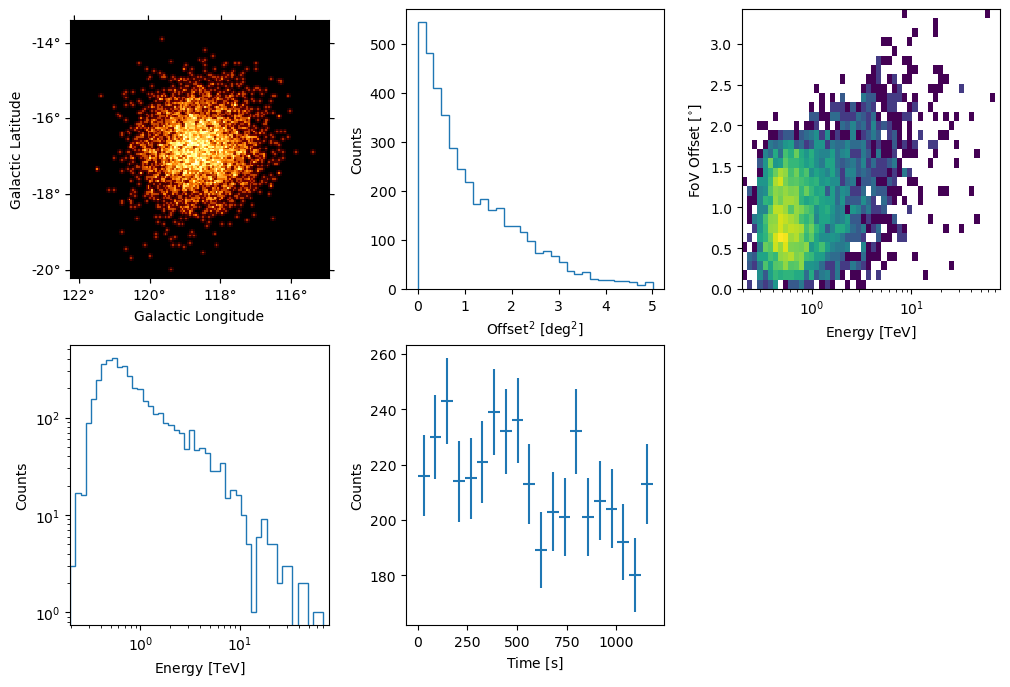

EFFECTIVE AREA SUMMARY:


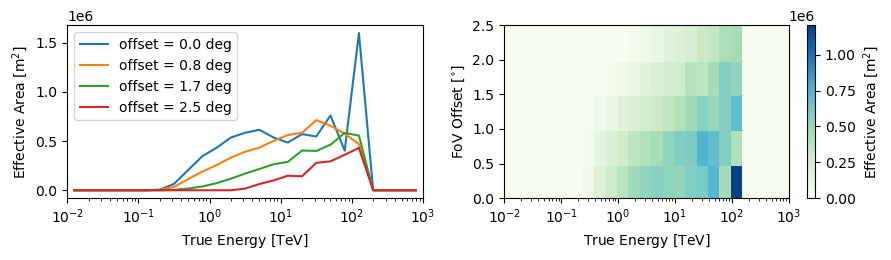

ENERGY DISPERSION SUMMARY:


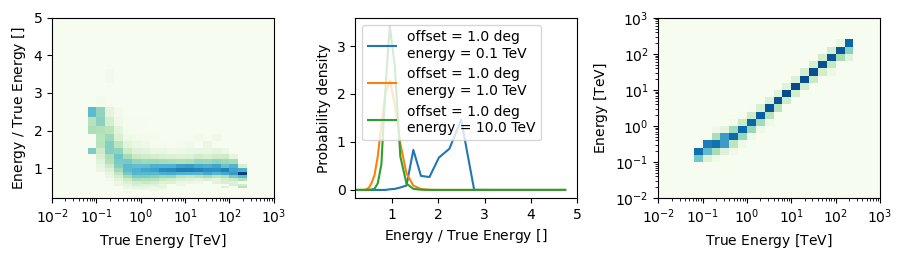

PSF SUMMARY:


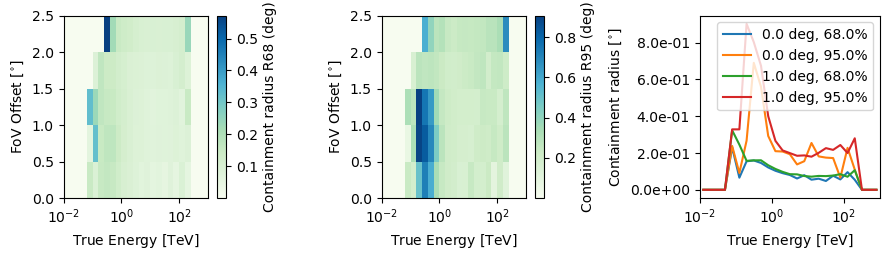

BACKGROUND SUMMARY:


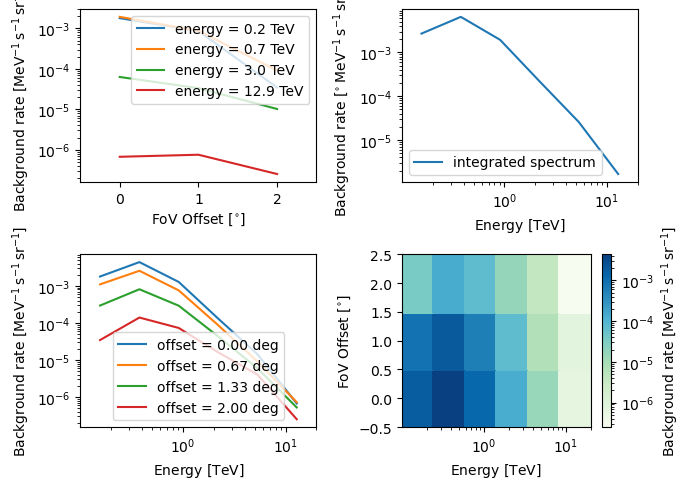

In [8]:
obs = obs_collection_real[0]
print("EVENTS SUMMARY:"); obs.events.peek(); plt.show()
print("EFFECTIVE AREA SUMMARY:"); obs.aeff.peek(figsize=(9, 2.7)); plt.show()
print("ENERGY DISPERSION SUMMARY:"); obs.edisp.peek(figsize=(9, 2.7)); plt.show()
print("PSF SUMMARY:"); obs.psf.peek(figsize=(9, 2.7)); plt.show()
print("BACKGROUND SUMMARY:"); obs.bkg.peek(figsize=(7, 5)); plt.show()

#### We run the pipeline for the real data to compare

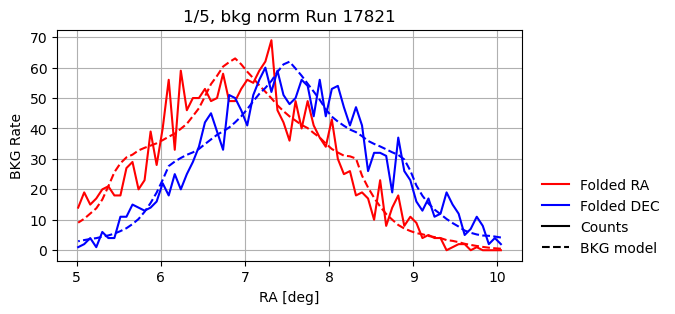

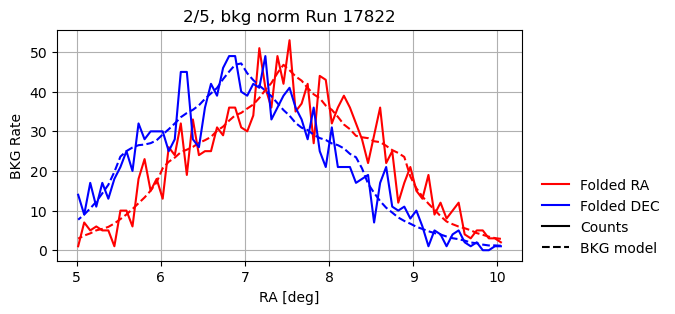

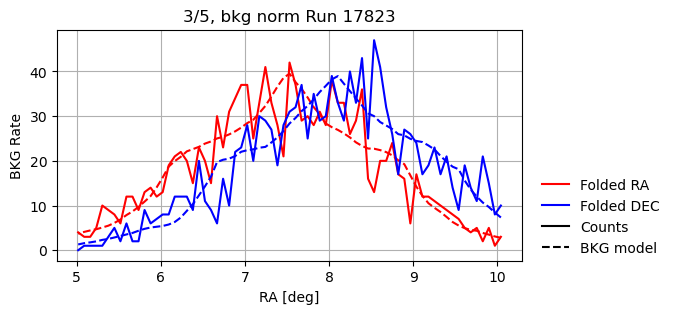

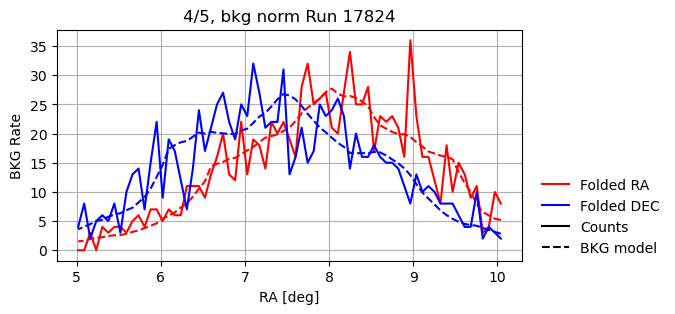

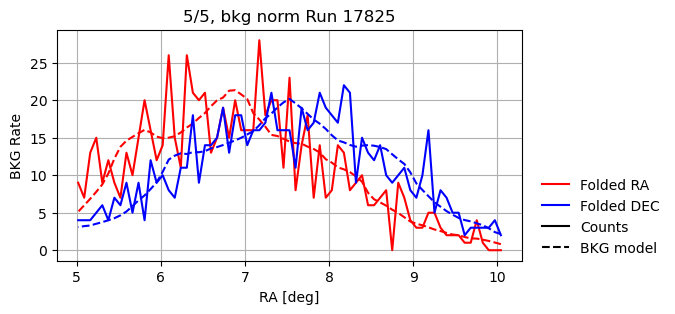

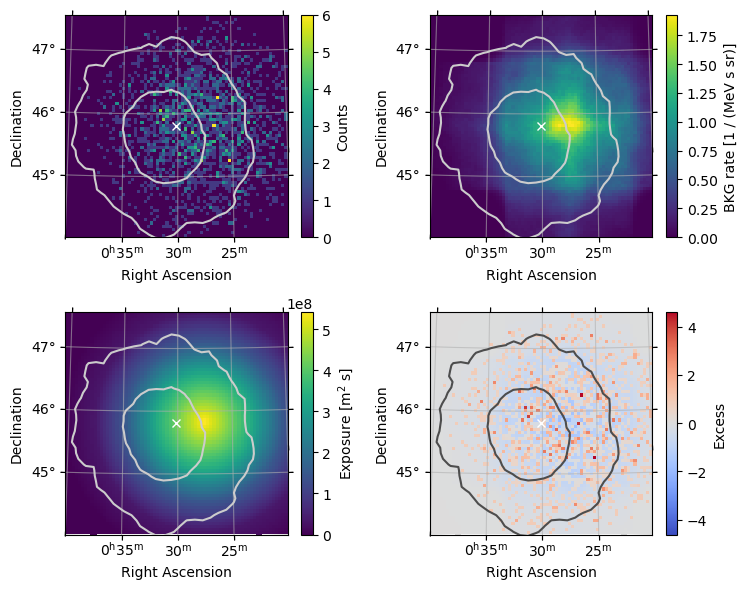

In [9]:
maker = MapDatasetMaker(selection=["counts", "background", "psf", "edisp", "exposure"])
# maker_safe_mask = SafeMaskMaker(methods=["aeff-default"])
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=size_fov)
maker_ring = RingBackgroundMaker(r_in=ring_r_in, width=ring_width)

# dataset_empty = MapDataset.create(geom, energy_axis_true=axis_energy_true)
# stacked_dataset_ring = MapDatasetOnOff.create(geom, energy_axis_true=axis_energy_true)
dataset_empty = MapDataset.create(geom)
dataset_stacked_real = MapDatasetOnOff.create(geom)
datasets_real, bkg_models = [], []

for i, obs in enumerate(obs_collection_real[:]):
    dataset = maker.run(dataset_empty.copy(), obs)
    dataset = maker_safe_mask.run(dataset, obs)
    dataset_on_off = maker_ring.run(dataset)
    
    datasets_real.append(dataset_on_off)
    dataset_stacked_real.stack(dataset_on_off)
    
    utils.summary_folded_counts(dataset_on_off, bin_c_ra, obs, i, len(obs_collection_real))
    
    # Storing the NORMALIZED bkg model
    bkg_models.append(dataset_on_off.background.copy())

datasets_all_real = Datasets(datasets_real)
    
# stacked_dataset_ring.peek(figsize=(7, 6))
utils.summary_maps(
    datasets_real[0], geom, bin_edges_ra, bin_edges_dec, data_ligo_2d, 
    threshold_maps, source_coord, source_name
)

### Defining the needed `ExcessMapEstimator`


In [10]:
energy_edges = [axis_energy.edges[0], axis_energy.edges[-1]]
    
spatial_model = PointSpatialModel(lon_0=source_coord.ra, lat_0=source_coord.dec)
spectral_model = PowerLawSpectralModel(index=2)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

excess_estimator = ExcessMapEstimator(
    correlation_radius = 0.1 * u.deg,
    correlate_off = True,
    spectral_model = spectral_model,
    energy_edges = energy_edges,
    selection_optional = "all",
)

### Computing $ \Lambda$ for the real data
Defined as the maximum $TS'$ in the 95% region.

In [11]:
stats_real = convolved_map_dataset_counts_statistics(
    dataset_stacked_real, 
    excess_estimator.estimate_kernel(dataset_stacked_real), 
    excess_estimator.estimate_mask_default(dataset_stacked_real), 
    excess_estimator.correlate_off
)

lik_alt  = cash(stats_real.n_on.sum(axis=0), stats_real.n_on.sum(axis=0))
lik_null = cash(stats_real.n_on.sum(axis=0), stats_real.n_bkg.sum(axis=0))
ts_sign  = np.where((stats_real.n_on.sum(axis=0) - stats_real.n_bkg.sum(axis=0)) >= 0.0, +1.0, -1.0)

# Setting minimum to 0, given some ~1e-6 fluctuations that can be produced
ts  = np.where((lik_null - lik_alt) < 0.0, 0.0, (lik_null - lik_alt))

ts2 = ts * ts_sign + 2 * np.log(prob_gw)

# Checking only in 95% area only
ts2_masked   = np.where(mask_threshold_95, ts2, np.nan)
ts2_argmax   = np.unravel_index(np.nanargmax(ts2_masked), ts2_masked.shape)
lambda_real  = np.nanmax(ts2_masked)
lambda_coord_real = SkyCoord(ra=bin_c_ra[ts2_argmax], dec=bin_c_dec[ts2_argmax], unit=u.deg, frame="icrs")

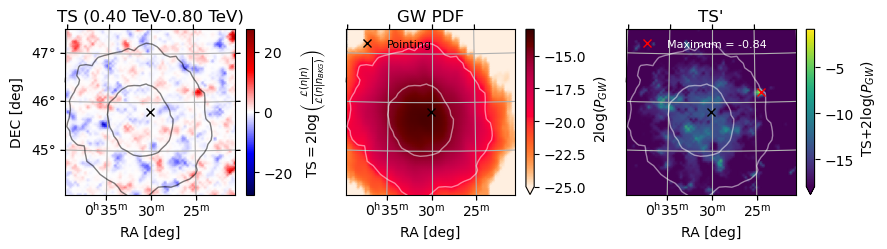

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 2.6), subplot_kw={"projection": geom.wcs})

tsmax = np.max(np.abs([np.nanmax(ts), np.nanmin(ts)]))
a1 = ax1.pcolormesh(
    bin_c_ra, bin_c_dec, ts * ts_sign, shading="gouraud",
    transform=ax1.get_transform("icrs"), cmap="seismic", vmin=-tsmax, vmax=tsmax
)
a2 = ax2.pcolormesh(
    bin_c_ra, bin_c_dec, log_gw, shading="gouraud", 
    transform=ax2.get_transform("icrs"), cmap="cylon", vmin=-25, vmax=-13,
)
a3 = ax3.pcolormesh(
    bin_c_ra, bin_c_dec, ts2, shading="gouraud", 
    transform=ax3.get_transform("icrs"), cmap="viridis", vmin=-18
)
fig.colorbar(a1, ax=ax1, label="TS$=2\log\\left(\\frac{\mathcal{L}(n|n)}{\mathcal{L}(n|n_{BKG})}\\right)$")
fig.colorbar(a2, ax=ax2, label="$2\log(P_{GW})$", extend="min")
fig.colorbar(a3, ax=ax3, label="TS$+2\log(P_{GW})$", extend="min")

for ax in [ax1, ax2, ax3]:
    lims = ax.get_xlim(), ax.get_ylim()
    ax.contour(
        data_ligo_2d, levels=threshold_maps, transform=ax.get_transform("icrs"), 
        origin="lower", linewidths=1, alpha=0.5,
        extent=[-180, 180, -90, 90], colors="w" if ax != ax1 else "k", 
    ); delta = 1.0
    ax.set_xlim(lims[0][0]+delta, lims[0][1]-delta); ax.set_ylim(lims[1][0]+delta, lims[1][1]-delta)

    ax.plot(source_coord.ra.deg, source_coord.dec.deg, "x", transform=ax.get_transform("icrs"),
            label="Pointing" if ax == ax2 else None, color="k", ls="")

    ax.set_xlabel("RA [deg]"); ax.grid()

ax3.plot(lambda_coord_real.ra.deg, lambda_coord_real.dec.deg, "x", transform=ax.get_transform("icrs"),
         label=f"Maximum = {lambda_real:.2f}", color="r", ls="")
    
for dec in (ax2.coords[1], ax3.coords[1]):
    dec.set_ticks_visible(False)
    dec.set_ticklabel_visible(False)

ax1.set_ylabel("DEC [deg]"); ax2.set_title("GW PDF"); ax3.set_title("TS'")
ax1.set_title(f"TS ({axis_energy.edges[0]:.2f}-{axis_energy.edges[-1]:.2f})")
ax2.legend(frameon=False, loc=2, fontsize=8)
l3 = ax3.legend(frameon=False, loc=2, fontsize=8)
for text in l3.get_texts():
    text.set_color("w")
plt.tight_layout()

plt.show()

### Computting the Sky-Map ULs for real data

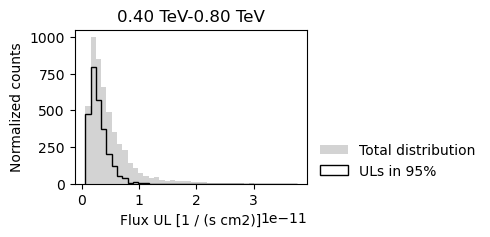

In [13]:
maps_real = excess_estimator.run(dataset_stacked_real)
flux_uls = maps_real["flux_ul"].data.ravel()
flux_uls_95 = np.where(mask_threshold_95, maps_real["flux_ul"].data, np.nan).ravel()

fig, ax = plt.subplots(figsize=(3, 2))

h = ax.hist(flux_uls, 40, histtype="stepfilled", color="lightgray", label="Total distribution")
ax.hist(flux_uls_95, h[1], histtype="step", color="k", label="ULs in 95%")

ax.set_xlabel("Flux UL [1 / (s cm2)]"); ax.set_ylabel("Normalized counts")
ax.set_title(f"{energy_edges[0]:.2f}-{energy_edges[1]:.2f}")
ax.legend(frameon=False, loc=(1.03, 0))

plt.show()

### Getting IRFs, pointing, and timing information from real data

In [14]:
# Getting the IRFs for each observation
obs_irfs, obs_time_ref, obs_pointing, obs_livetime = [], [], [], []
for i, obs_id in enumerate(obs_ids):
    hdu_tab = data_store_real.hdu_table[data_store_real.hdu_table["OBS_ID"] == obs_id]
    obs_tab = data_store_real.obs_table[data_store_real.obs_table["OBS_ID"] == obs_id]
    
    path_dl3 = os.path.join(dir_dl3, hdu_tab[hdu_tab["HDU_NAME"] == "EVENTS"]["FILE_NAME"][0])
    path_bkg = os.path.join(dir_dl3, hdu_tab[hdu_tab["HDU_NAME"] == "BACKGROUND"]["FILE_NAME"][0])
    
    _irfs_, _irf_bkg_ = load_irf_dict_from_file(path_dl3), load_irf_dict_from_file(path_bkg)
    _irfs_.update(_irf_bkg_)

    obs_irfs.append(_irfs_)
    obs_time_ref.append(Time(f"{obs_tab['DATE-OBS'][0]} {obs_tab['TIME-OBS'][0]}", scale="utc"))
    obs_pointing.append(SkyCoord(ra=obs_tab["RA_PNT"][0], dec=obs_tab["DEC_PNT"][0], unit=u.deg, frame="icrs"))
    obs_livetime.append(np.sum(obs_tab["LIVETIME"]))
    print(f"\nRun {obs_id}\n - IRFs: {list(_irfs_.keys())}\n - Livetime {obs_livetime[-1]/60:.2f} min")
    print(f" - Time Ref {obs_time_ref[-1]}")
    print(f" - Pointing (RA={obs_tab['RA_PNT'][0]:.2f}, DEC={obs_tab['DEC_PNT'][0]:.2f})deg")


Run 17821
 - IRFs: ['aeff', 'edisp', 'psf', 'bkg']
 - Livetime 18.72 min
 - Time Ref 2024-06-16 02:57:34.723
 - Pointing (RA=6.89, DEC=45.83)deg

Run 17822
 - IRFs: ['aeff', 'edisp', 'psf', 'bkg']
 - Livetime 18.43 min
 - Time Ref 2024-06-16 03:17:59.632
 - Pointing (RA=7.46, DEC=46.23)deg

Run 17823
 - IRFs: ['aeff', 'edisp', 'psf', 'bkg']
 - Livetime 18.54 min
 - Time Ref 2024-06-16 03:38:29.523
 - Pointing (RA=7.50, DEC=45.41)deg

Run 17824
 - IRFs: ['aeff', 'edisp', 'psf', 'bkg']
 - Livetime 18.67 min
 - Time Ref 2024-06-16 03:58:47.554
 - Pointing (RA=8.03, DEC=45.83)deg

Run 17825
 - IRFs: ['aeff', 'edisp', 'psf', 'bkg']
 - Livetime 18.78 min
 - Time Ref 2024-06-16 04:19:11.960
 - Pointing (RA=6.92, DEC=45.81)deg


#### Generating the Observations object and filling it with BKG (we can fill it with `.fake()`)

In [15]:
observations = [Observation.create(
    obs_id = f"{i}",
    pointing = obs_pointing[i], # FixedPointingInfo(fixed_icrs=obs_pointing[i]), 
    livetime = obs_livetime[i] * u.s, 
    irfs = obs_irfs[i], 
    location = observing_location,
    reference_time = obs_time_ref[i],
) for i in range(len(obs_irfs))]

maker = MapDatasetMaker(selection=["background", "psf", "edisp", "exposure"])
# maker_safe_mask = SafeMaskMaker(methods=["aeff-default"])
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=size_fov)

/home/juan.jimenez/.conda/envs/baseenv/lib/python3.11/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


### We create a empty unique dataset for the observations

We still need to set the `model` and then simulate the events `.fake()` later.

In [16]:
dataset_empty = MapDataset.create(geom)
dataset_stacked_simulated = MapDataset.create(geom)

datasets_simulated = []
for i, obs in enumerate(observations):
    dataset = maker.run(dataset_empty.copy(), obs)
    dataset = maker_safe_mask.run(dataset, obs)
    
    dataset.background = bkg_models[i]
    
    datasets_simulated.append(dataset)
    dataset_stacked_simulated.stack(dataset)
    
#     utils.summary_folded_counts(dataset, bin_c_ra, obs, i, len(observations))

datasets_all_simulated = Datasets(datasets_simulated)

# datasets_simulated[0].peek(figsize=(7, 6))
# utils.summary_maps(
#     datasets_simulated[0], geom, bin_edges_ra, bin_edges_dec, data_ligo_2d, 
#     threshold_maps, source_coord, source_name
# )

### Defining the needed input parameters in the simulations

In order to perform the simulations we store the relevant information into a `.pkl` file:
* The ExcessMapEstimator
* The empty dataset to be simulated (all runs contained)
* The GW SkyMap converted into WCS map
* The mask of the Map for the 95% region

In [17]:
# From dl3 directory we check if is mono or stereo data
type_obs  = "mono" if "mono" in dir_dl3.lower() else "stereo" if "stereo" in dir_dl3.lower() else "unknown"
fname_pkl = f"{source_name}_{type_obs}_E_{e_min.value}_{e_max.value}.pkl"
path_pkl  = os.path.join("data", "tmp", fname_pkl)
with open(path_pkl, "wb") as file:
    data_pkl = (dataset_stacked_simulated, excess_estimator, prob_gw, data_ligo_hp, mask_threshold_95)
    pickle.dump(data_pkl, file)

# Launching the BKG simulations

In [19]:
n_sim_bkg   = 50000
compute_uls = 0
flux_bkg    = 0.0

# First we check if the results file already exists
fname_results_bkg  = f"{source_name}_{type_obs}_E_{e_min.value}_{e_max.value}"
fname_results_bkg += f"_N_{n_sim_bkg}_f_{flux_bkg}_{'extended' if bool(compute_uls) else ''}.npz"
path_results_bkg = os.path.join("data", "results", fname_results_bkg)

# If data is not already produced
if not os.path.exists(path_results_bkg):
    
    # For the background there is no need of sending jobs as is only one simulation
    # Can take O(5-10min) for a decent amount of statistics to compute the distribution
    utils.perform_n_simulations(
        n_sim = n_sim_bkg,
        flux = flux_bkg,
        file_input = path_pkl,
        file_output = path_results_bkg,
        compute_uls = compute_uls
    )
else:
    print(f"Data already exists\n")

# Then we load the data always from the files
print(f"\nLoading for N={n_sim_bkg}...")
data_bkg = np.load(path_results_bkg)

lambda_bkg = data_bkg["lambda_data"]
lambda_ra_bkg, lambda_dec_bkg = data_bkg["lambda_ra"], data_bkg["lambda_dec"]

tsmax_bkg = data_bkg["tsmax"]
tsmax_ra_bkg, tsmax_dec_bkg = data_bkg["tsmax_ra"], data_bkg["tsmax_dec"]

ts_dist  = data_bkg["ts_dist"]
ts2_dist = data_bkg["ts2_dist"]
f_ra_bkg, f_dec_bkg = data_bkg["f_ra"], data_bkg["f_dec"]

if compute_uls:
    ulmax_bkg = data_bkg["ulmax"]
    ulmax_ra_bkg, ulmax_dec_bkg = data_bkg["ulmax_ra"], data_bkg["ulmax_dec"]

    ul_dist = data_bkg["ul_dist"]

Producing 50000 simulations without computing the flux maps.
Setting up everything...



Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.39302089, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.39302089, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.30540746, 43.76723527)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.30540746, 43.76723527)> is outside valid IRF map range, using nearest IRF defined within


Computing... 250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.85877863, 43.87897785)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.85877863, 43.87897785)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.45034642, 44.28830516)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.45034642, 44.28830516)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.44537815, 43.91621507)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.44537815, 43.91621507)> is outside valid IRF map range, using nearest IRF defined within


Computing... 500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.65593306, 43.70513597)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.65593306, 43.70513597)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.13801262, 45.43857893)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.13801262, 45.43857893)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.13331573, 45.63599563)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.13331573, 45.63599563)> is outside valid IRF map range, using nearest IRF defined within


Computing... 750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.27785164, 45.96882253)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.27785164, 45.96882253)> is outside valid IRF map range, using nearest IRF defined within


Computing... 1000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.17009494, 45.58665448)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.17009494, 45.58665448)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.25342466, 43.72997742)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.25342466, 43.72997742)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.43667546, 45.61132614)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.43667546, 45.61132614)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.13022176, 44.5236988)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoo

Computing... 1250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.85797342, 47.79862362)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.85797342, 47.79862362)> is outside valid IRF map range, using nearest IRF defined within


Computing... 1500/50000
Computing... 1750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.81862122, 43.8665643)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.81862122, 43.8665643)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.2661597, 43.69271438)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.2661597, 43.69271438)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.12204724, 45.36451177)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.12204724, 45.36451177)> is outside valid IRF map range, using nearest IRF defined within


Computing... 2000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.52695604, 47.73740637)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.52695604, 47.73740637)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.81663276, 43.85415018)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.81663276, 43.85415018)> is outside valid IRF map range, using nearest IRF defined within


Computing... 2250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.77168367, 44.00308189)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.77168367, 44.00308189)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.82061069, 43.87897785)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.82061069, 43.87897785)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.03340133, 43.97826566)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.03340133, 43.97826566)> is outside valid IRF map range, using nearest IRF defined within


Computing... 2500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.11489699, 45.66066295)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.11489699, 45.66066295)> is outside valid IRF map range, using nearest IRF defined within


Computing... 2750/50000
Computing... 3000/50000
Computing... 3250/50000
Computing... 3500/50000
Computing... 3750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.33236229, 45.78396716)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.33236229, 45.78396716)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.21079484, 46.4242854)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.21079484, 46.4242854)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.3242486, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.3242486, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within


Computing... 4000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.25630252, 48.31235288)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.25630252, 48.31235288)> is outside valid IRF map range, using nearest IRF defined within


Computing... 4250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.65944982, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.65944982, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.88623596, 48.4345398)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.88623596, 48.4345398)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.53188776, 44.00308189)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.53188776, 44.00308189)> is outside valid IRF map range, using nearest IRF defined within


Computing... 4500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.97742835, 43.71755698)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.97742835, 43.71755698)> is outside valid IRF map range, using nearest IRF defined within


Computing... 4750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.3335091, 45.57431784)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.3335091, 45.57431784)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.90973312, 45.21631842)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.90973312, 45.21631842)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.62174941, 45.40154781)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.62174941, 45.40154781)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.67097264, 43.65544616)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (

Computing... 5000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.77833753, 48.27568714)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.77833753, 48.27568714)> is outside valid IRF map range, using nearest IRF defined within


Computing... 5250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.6875, 47.9454936)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.6875, 47.9454936)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.61594203, 46.39968435)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.61594203, 46.39968435)> is outside valid IRF map range, using nearest IRF defined within


Computing... 5500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.80380795, 47.65168097)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.80380795, 47.65168097)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.33430233, 45.68532812)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.33430233, 45.68532812)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.40195045, 45.56198065)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.40195045, 45.56198065)> is outside valid IRF map range, using nearest IRF defined within


Computing... 5750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.25735294, 47.06317658)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.25735294, 47.06317658)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.28706062, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.28706062, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.28287841, 47.61493391)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.28287841, 47.61493391)> is outside valid IRF map range, using nearest IRF defined within


Computing... 6000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.00886076, 43.6305978)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.00886076, 43.6305978)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.25696203, 43.6305978)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.25696203, 43.6305978)> is outside valid IRF map range, using nearest IRF defined within


Computing... 6250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.83995554, 47.9577295)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.83995554, 47.9577295)> is outside valid IRF map range, using nearest IRF defined within


Computing... 6500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.13175059, 45.08040512)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.13175059, 45.08040512)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.60740145, 46.36277882)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.60740145, 46.36277882)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.36488201, 43.74239728)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.36488201, 43.74239728)> is outside valid IRF map range, using nearest IRF defined within


Computing... 6750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.39732494, 45.32747082)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.39732494, 45.32747082)> is outside valid IRF map range, using nearest IRF defined within


Computing... 7000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.13033175, 45.51262649)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.13033175, 45.51262649)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.59319764, 46.30125901)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.59319764, 46.30125901)> is outside valid IRF map range, using nearest IRF defined within


Computing... 7250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.52362205, 45.36451177)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.52362205, 45.36451177)> is outside valid IRF map range, using nearest IRF defined within


Computing... 7500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.36446933, 43.89139083)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.36446933, 43.89139083)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.45055781, 43.70513597)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.45055781, 43.70513597)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.6300357, 43.97826566)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.6300357, 43.97826566)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.97836471, 48.44675576)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (IC

Computing... 7750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.91497462, 43.75481656)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.91497462, 43.75481656)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.20728809, 45.64832956)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.20728809, 45.64832956)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.70280612, 44.00308189)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.70280612, 44.00308189)> is outside valid IRF map range, using nearest IRF defined within


Computing... 8000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.33409611, 43.84173549)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.33409611, 43.84173549)> is outside valid IRF map range, using nearest IRF defined within


Computing... 8250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.79482627, 43.71755698)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.79482627, 43.71755698)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.18494568, 44.67226404)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.18494568, 44.67226404)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.35909467, 47.66392897)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.35909467, 47.66392897)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.16751541, 46.33817248)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoor

Computing... 8500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.48937954, 48.21456764)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.48937954, 48.21456764)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.62808446, 43.8665643)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.62808446, 43.8665643)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.90295466, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.90295466, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.41171706, 46.67018005)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (I

Computing... 8750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.1098649, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.1098649, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within


Computing... 9000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.65931034, 47.63943245)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.65931034, 47.63943245)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.0025208, 43.41929337)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.0025208, 43.41929337)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (9.32533113, 47.65168097)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (9.32533113, 47.65168097)> is outside valid IRF map range, using nearest IRF defined within


Computing... 9250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.59517766, 43.75481656)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.59517766, 43.75481656)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.64181399, 44.21392802)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.64181399, 44.21392802)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.59437855, 44.5236988)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.59437855, 44.5236988)> is outside valid IRF map range, using nearest IRF defined within


Computing... 9500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.64216684, 43.85415018)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.64216684, 43.85415018)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.61458068, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.61458068, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.02715047, 43.74239728)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.02715047, 43.74239728)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.96470289, 43.77965341)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (

Computing... 9750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.20365169, 48.4345398)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.20365169, 48.4345398)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.49235084, 43.97826566)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.49235084, 43.97826566)> is outside valid IRF map range, using nearest IRF defined within


Computing... 10000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.94704741, 47.85982826)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.94704741, 47.85982826)> is outside valid IRF map range, using nearest IRF defined within


Computing... 10250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.0351951, 43.99067406)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.0351951, 43.99067406)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.48090631, 43.90380323)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.48090631, 43.90380323)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.43770764, 47.79862362)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.43770764, 47.79862362)> is outside valid IRF map range, using nearest IRF defined within


Computing... 10500/50000
Computing... 10750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.85354691, 43.84173549)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.85354691, 43.84173549)> is outside valid IRF map range, using nearest IRF defined within


Computing... 11000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.44472681, 43.81690438)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.44472681, 43.81690438)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.78273051, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.78273051, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.93450114, 43.76723527)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.93450114, 43.76723527)> is outside valid IRF map range, using nearest IRF defined within


Computing... 11250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.43667546, 45.61132614)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.43667546, 45.61132614)> is outside valid IRF map range, using nearest IRF defined within


Computing... 11500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.83862876, 48.09229126)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.83862876, 48.09229126)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.28674313, 46.11662003)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.28674313, 46.11662003)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.05236628, 48.30013147)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.05236628, 48.30013147)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.39526597, 43.89139083)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord

Computing... 11750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.27568585, 46.49807588)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.27568585, 46.49807588)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.34140745, 43.97826566)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.34140745, 43.97826566)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.23054371, 46.07967786)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.23054371, 46.07967786)> is outside valid IRF map range, using nearest IRF defined within


Computing... 12000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.61256678, 43.8665643)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.61256678, 43.8665643)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.85951045, 43.97826566)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.85951045, 43.97826566)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.16741366, 45.57431784)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.16741366, 45.57431784)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.00993125, 43.91621507)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (

Computing... 12250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.14034627, 45.33981835)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.14034627, 45.33981835)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.70965956, 47.78638118)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.70965956, 47.78638118)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.08742171, 45.09276363)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.08742171, 45.09276363)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.56312165, 43.99067406)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoo

Computing... 12500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.37385321, 43.95344713)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.37385321, 43.95344713)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.51050647, 46.57184741)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.51050647, 46.57184741)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.87908405, 48.17788996)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.87908405, 48.17788996)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.21704815, 45.47560516)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoor

Computing... 12750/50000
Computing... 13000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.49619675, 43.70513597)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.49619675, 43.70513597)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.19285529, 44.70939278)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.19285529, 44.70939278)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.2391649, 45.68532812)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.2391649, 45.68532812)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.58530806, 45.51262649)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord

Computing... 13250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.20755222, 46.30125901)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.20755222, 46.30125901)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.67245658, 47.61493391)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.67245658, 47.61493391)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.20962812, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.20962812, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within


Computing... 13500/50000
Computing... 13750/50000
Computing... 14000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.31839623, 45.29042495)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.31839623, 45.29042495)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.11646166, 45.22867088)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.11646166, 45.22867088)> is outside valid IRF map range, using nearest IRF defined within


Computing... 14250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.72248406, 47.85982826)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.72248406, 47.85982826)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.54816514, 43.95344713)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.54816514, 43.95344713)> is outside valid IRF map range, using nearest IRF defined within


Computing... 14500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.4738255, 46.41198514)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.4738255, 46.41198514)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.25510204, 45.21631842)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.25510204, 45.21631842)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.3063371, 45.45092155)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.3063371, 45.45092155)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.69966722, 47.87206767)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord

Computing... 14750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.20573497, 48.04336672)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.20573497, 48.04336672)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.95281457, 47.65168097)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.95281457, 47.65168097)> is outside valid IRF map range, using nearest IRF defined within


Computing... 15000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.14702218, 42.84668361)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.14702218, 42.84668361)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (9.119436, 47.73740637)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (9.119436, 47.73740637)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.1814059, 43.39442302)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.1814059, 43.39442302)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.65446224, 43.84173549)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS):

Computing... 15250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.52209363, 45.46326363)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.52209363, 45.46326363)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.1559633, 45.30277412)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.1559633, 45.30277412)> is outside valid IRF map range, using nearest IRF defined within


Computing... 15500/50000
Computing... 15750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.32567568, 46.7193338)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.32567568, 46.7193338)> is outside valid IRF map range, using nearest IRF defined within


Computing... 16000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.14811849, 46.14124547)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.14811849, 46.14124547)> is outside valid IRF map range, using nearest IRF defined within


Computing... 16250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.78186897, 43.77965341)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.78186897, 43.77965341)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.45230854, 47.73740637)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.45230854, 47.73740637)> is outside valid IRF map range, using nearest IRF defined within


Computing... 16500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.81663276, 43.85415018)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.81663276, 43.85415018)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.21130552, 46.53496401)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.21130552, 46.53496401)> is outside valid IRF map range, using nearest IRF defined within


Computing... 16750/50000
Computing... 17000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.76865672, 47.7251614)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.76865672, 47.7251614)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.39898348, 43.81690438)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.39898348, 43.81690438)> is outside valid IRF map range, using nearest IRF defined within


Computing... 17250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.65850515, 44.49893008)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.65850515, 44.49893008)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.27521728, 45.52496584)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.27521728, 45.52496584)> is outside valid IRF map range, using nearest IRF defined within


Computing... 17500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.2145749, 46.65789031)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.2145749, 46.65789031)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.1481387, 43.97826566)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.1481387, 43.97826566)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.12674625, 43.79207097)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.12674625, 43.79207097)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.91296625, 43.74239728)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (IC

Computing... 17750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.34624146, 43.61817276)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.34624146, 43.61817276)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.2690167, 45.82094791)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.2690167, 45.82094791)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.01910828, 43.94103702)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.01910828, 43.94103702)> is outside valid IRF map range, using nearest IRF defined within


Computing... 18000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.95801527, 43.87897785)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.95801527, 43.87897785)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.8957334, 43.49389052)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.8957334, 43.49389052)> is outside valid IRF map range, using nearest IRF defined within


Computing... 18250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.96530767, 43.64302227)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.96530767, 43.64302227)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.78707224, 43.69271438)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.78707224, 43.69271438)> is outside valid IRF map range, using nearest IRF defined within


Computing... 18500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.92946058, 47.76189479)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.92946058, 47.76189479)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.38549618, 43.87897785)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.38549618, 43.87897785)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.26624204, 43.94103702)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.26624204, 43.94103702)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.13175059, 45.08040512)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord 

Computing... 18750/50000
Computing... 19000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.88009992, 47.9087829)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.88009992, 47.9087829)> is outside valid IRF map range, using nearest IRF defined within


Computing... 19250/50000
Computing... 19500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.51184211, 45.48794615)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.51184211, 45.48794615)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.24973849, 45.19161186)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.24973849, 45.19161186)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.74646107, 43.55603887)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.74646107, 43.55603887)> is outside valid IRF map range, using nearest IRF defined within


Computing... 19750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.23623853, 43.95344713)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.23623853, 43.95344713)> is outside valid IRF map range, using nearest IRF defined within


Computing... 20000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.29637148, 43.74239728)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.29637148, 43.74239728)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.20455161, 46.82989917)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.20455161, 46.82989917)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.65517241, 45.50028659)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.65517241, 45.50028659)> is outside valid IRF map range, using nearest IRF defined within


Computing... 20250/50000
Computing... 20500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.08557765, 43.34467532)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.08557765, 43.34467532)> is outside valid IRF map range, using nearest IRF defined within


Computing... 20750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.4059633, 43.95344713)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.4059633, 43.95344713)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.43676696, 43.97826566)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.43676696, 43.97826566)> is outside valid IRF map range, using nearest IRF defined within


Computing... 21000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.36208299, 46.87902578)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.36208299, 46.87902578)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.73374139, 43.99067406)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.73374139, 43.99067406)> is outside valid IRF map range, using nearest IRF defined within


Computing... 21250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.30926467, 45.89489488)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.30926467, 45.89489488)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.12271341, 43.80448796)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.12271341, 43.80448796)> is outside valid IRF map range, using nearest IRF defined within


Computing... 21500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.4964449, 43.77965341)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.4964449, 43.77965341)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.65575883, 44.48654488)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.65575883, 44.48654488)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.63092206, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.63092206, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.02767902, 43.77965341)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (

Computing... 21750/50000
Computing... 22000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.12766518, 45.50028659)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.12766518, 45.50028659)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.02209243, 43.77965341)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.02209243, 43.77965341)> is outside valid IRF map range, using nearest IRF defined within


Computing... 22250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.7508172, 43.29491831)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.7508172, 43.29491831)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.33083311, 46.31356403)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.33083311, 46.31356403)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.25145459, 43.59332093)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.25145459, 43.59332093)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.33928116, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (

Computing... 22500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.19219985, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.19219985, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.71199389, 43.91621507)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.71199389, 43.91621507)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.5828877, 43.91621507)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.5828877, 43.91621507)> is outside valid IRF map range, using nearest IRF defined within


Computing... 22750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.17485318, 46.1535574)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.17485318, 46.1535574)> is outside valid IRF map range, using nearest IRF defined within


Computing... 23000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.80816016, 43.68029222)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.80816016, 43.68029222)> is outside valid IRF map range, using nearest IRF defined within


Computing... 23250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.31920832, 43.74239728)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.31920832, 43.74239728)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.69474562, 47.98219978)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.69474562, 47.98219978)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.4187643, 43.84173549)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.4187643, 43.84173549)> is outside valid IRF map range, using nearest IRF defined within


Computing... 23500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.60361507, 43.90380323)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.60361507, 43.90380323)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.43460818, 46.23972597)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.43460818, 46.23972597)> is outside valid IRF map range, using nearest IRF defined within


Computing... 23750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.6890352, 43.64302227)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.6890352, 43.64302227)> is outside valid IRF map range, using nearest IRF defined within


Computing... 24000/50000
Computing... 24250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.46380493, 43.79207097)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.46380493, 43.79207097)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.77906977, 44.62275125)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.77906977, 44.62275125)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.2509196, 45.41389206)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.2509196, 45.41389206)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.15975706, 45.64832956)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoor

Computing... 24500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.05501257, 48.17788996)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.05501257, 48.17788996)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.63392857, 44.00308189)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.63392857, 44.00308189)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.36046512, 44.62275125)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.36046512, 44.62275125)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.20568095, 43.71755698)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord

Computing... 24750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.0328495, 43.91621507)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.0328495, 43.91621507)> is outside valid IRF map range, using nearest IRF defined within


Computing... 25000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.80297502, 48.39788892)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.80297502, 48.39788892)> is outside valid IRF map range, using nearest IRF defined within


Computing... 25250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.36284813, 45.41389206)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.36284813, 45.41389206)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.72706422, 43.95344713)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.72706422, 43.95344713)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.125, 45.48794615)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.125, 45.48794615)> is outside valid IRF map range, using nearest IRF defined within


Computing... 25500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.9645589, 43.97826566)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.9645589, 43.97826566)> is outside valid IRF map range, using nearest IRF defined within


Computing... 25750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.86672185, 47.65168097)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.86672185, 47.65168097)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.89742307, 43.04599302)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.89742307, 43.04599302)> is outside valid IRF map range, using nearest IRF defined within


Computing... 26000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.49551996, 46.92814407)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.49551996, 46.92814407)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.382134, 47.61493391)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.382134, 47.61493391)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.126498, 46.0427309)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.126498, 46.0427309)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.46391492, 43.64302227)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS):

Computing... 26250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.4233352, 48.26346424)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.4233352, 48.26346424)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.99515677, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.99515677, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within


Computing... 26500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.33577215, 45.1545479)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.33577215, 45.1545479)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.13599155, 45.64832956)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.13599155, 45.64832956)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.03705768, 48.08006087)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.03705768, 48.08006087)> is outside valid IRF map range, using nearest IRF defined within


Computing... 26750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.0984933, 48.14120779)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.0984933, 48.14120779)> is outside valid IRF map range, using nearest IRF defined within


Computing... 27000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.95923567, 43.94103702)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.95923567, 43.94103702)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.19071752, 46.11662003)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.19071752, 46.11662003)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.10022722, 43.49389052)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.10022722, 43.49389052)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.18169761, 45.85792381)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoor

Computing... 27250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.2223071, 43.91621507)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.2223071, 43.91621507)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.43150685, 43.72997742)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.43150685, 43.72997742)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.14334561, 45.46326363)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.14334561, 45.46326363)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.36782538, 46.58414083)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord 

Computing... 27500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.52311436, 46.73162093)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.52311436, 46.73162093)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.1536643, 45.40154781)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.1536643, 45.40154781)> is outside valid IRF map range, using nearest IRF defined within


Computing... 27750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.55011477, 43.99067406)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.55011477, 43.99067406)> is outside valid IRF map range, using nearest IRF defined within


Computing... 28000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.95006935, 47.88430659)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.95006935, 47.88430659)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.21410387, 43.90380323)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.21410387, 43.90380323)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.07388535, 43.94103702)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.07388535, 43.94103702)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.70379147, 45.51262649)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (

Computing... 28250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (9.07804132, 43.99067406)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (9.07804132, 43.99067406)> is outside valid IRF map range, using nearest IRF defined within


Computing... 28500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.5880102, 44.00308189)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.5880102, 44.00308189)> is outside valid IRF map range, using nearest IRF defined within


Computing... 28750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.56723511, 48.22679253)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.56723511, 48.22679253)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.12452351, 43.81690438)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.12452351, 43.81690438)> is outside valid IRF map range, using nearest IRF defined within


Computing... 29000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.11068702, 43.87897785)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.11068702, 43.87897785)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.53056546, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.53056546, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.4275178, 43.85415018)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.4275178, 43.85415018)> is outside valid IRF map range, using nearest IRF defined within


Computing... 29250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.54428044, 45.56198065)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.54428044, 45.56198065)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.79395817, 44.58561078)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.79395817, 44.58561078)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.06668357, 43.70513597)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.06668357, 43.70513597)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.51659488, 43.66786948)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoo

Computing... 29500/50000
Computing... 29750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.21059783, 46.96497734)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.21059783, 46.96497734)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.50840673, 46.14124547)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.50840673, 46.14124547)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.43104767, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.43104767, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.99312452, 43.91621507)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoo

Computing... 30000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.86775985, 45.72232181)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.86775985, 45.72232181)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.11611917, 43.91621507)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.11611917, 43.91621507)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.44323895, 45.74698157)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.44323895, 45.74698157)> is outside valid IRF map range, using nearest IRF defined within


Computing... 30250/50000
Computing... 30500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.25301521, 45.31512274)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.25301521, 45.31512274)> is outside valid IRF map range, using nearest IRF defined within


Computing... 30750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.02423469, 44.00308189)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.02423469, 44.00308189)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.54388196, 43.8665643)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.54388196, 43.8665643)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.65493497, 43.99067406)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.65493497, 43.99067406)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.93264659, 45.66066295)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (IC

Computing... 31000/50000
Computing... 31250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.14428691, 47.98219978)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.14428691, 47.98219978)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.66811004, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.66811004, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within


Computing... 31500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.1747449, 44.00308189)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.1747449, 44.00308189)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.21882173, 43.99067406)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.21882173, 43.99067406)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.79265493, 43.99067406)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.79265493, 43.99067406)> is outside valid IRF map range, using nearest IRF defined within


Computing... 31750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.41835906, 46.80533274)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.41835906, 46.80533274)> is outside valid IRF map range, using nearest IRF defined within


Computing... 32000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.01697922, 43.68029222)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.01697922, 43.68029222)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.16116751, 43.75481656)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.16116751, 43.75481656)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.95332823, 43.99067406)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.95332823, 43.99067406)> is outside valid IRF map range, using nearest IRF defined within


Computing... 32250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.013833, 43.30735844)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.013833, 43.30735844)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.21514147, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.21514147, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within


Computing... 32500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.17546174, 45.61132614)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.17546174, 45.61132614)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.65885142, 45.53730466)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.65885142, 45.53730466)> is outside valid IRF map range, using nearest IRF defined within


Computing... 32750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.74255915, 43.8665643)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.74255915, 43.8665643)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.19710378, 46.36277882)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.19710378, 46.36277882)> is outside valid IRF map range, using nearest IRF defined within


Computing... 33000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.42965573, 46.85446351)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.42965573, 46.85446351)> is outside valid IRF map range, using nearest IRF defined within


Computing... 33250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.08419689, 44.7465165)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.08419689, 44.7465165)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.10929681, 45.52496584)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.10929681, 45.52496584)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.67963576, 47.65168097)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.67963576, 47.65168097)> is outside valid IRF map range, using nearest IRF defined within


Computing... 33500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.01145892, 48.21456764)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.01145892, 48.21456764)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.77800356, 43.79207097)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.77800356, 43.79207097)> is outside valid IRF map range, using nearest IRF defined within


Computing... 33750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.10638298, 45.40154781)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.10638298, 45.40154781)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.84708554, 43.46902712)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.84708554, 43.46902712)> is outside valid IRF map range, using nearest IRF defined within


Computing... 34000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (9.44937587, 47.88430659)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (9.44937587, 47.88430659)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (9.39205955, 47.61493391)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (9.39205955, 47.61493391)> is outside valid IRF map range, using nearest IRF defined within


Computing... 34250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.68963601, 47.9577295)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.68963601, 47.9577295)> is outside valid IRF map range, using nearest IRF defined within


Computing... 34500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.96499028, 47.9577295)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.96499028, 47.9577295)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.38944147, 43.99067406)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.38944147, 43.99067406)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.82559025, 43.76723527)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.82559025, 43.76723527)> is outside valid IRF map range, using nearest IRF defined within


Computing... 34750/50000
Computing... 35000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.87313433, 47.7251614)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.87313433, 47.7251614)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.34191472, 46.36277882)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.34191472, 46.36277882)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.31845997, 43.97826566)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.31845997, 43.97826566)> is outside valid IRF map range, using nearest IRF defined within


Computing... 35250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.74599542, 43.84173549)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.74599542, 43.84173549)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.78074866, 43.91621507)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.78074866, 43.91621507)> is outside valid IRF map range, using nearest IRF defined within


Computing... 35500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.63311359, 43.70513597)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.63311359, 43.70513597)> is outside valid IRF map range, using nearest IRF defined within


Computing... 35750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.28605641, 46.00577912)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.28605641, 46.00577912)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.94724771, 43.95344713)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.94724771, 43.95344713)> is outside valid IRF map range, using nearest IRF defined within


Computing... 36000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.17884714, 44.42461045)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.17884714, 44.42461045)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.13899921, 45.77163917)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.13899921, 45.77163917)> is outside valid IRF map range, using nearest IRF defined within


Computing... 36250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.02761737, 43.2202653)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.02761737, 43.2202653)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.64474352, 43.77965341)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.64474352, 43.77965341)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.87306416, 47.74965083)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.87306416, 47.74965083)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.2606255, 46.21510903)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (IC

Computing... 36500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.673974, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.673974, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within


Computing... 36750/50000
Computing... 37000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.67330677, 45.91953958)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.67330677, 45.91953958)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.26821457, 46.14124547)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.26821457, 46.14124547)> is outside valid IRF map range, using nearest IRF defined within


Computing... 37250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.14753682, 43.77965341)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.14753682, 43.77965341)> is outside valid IRF map range, using nearest IRF defined within


Computing... 37500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.18533123, 45.43857893)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.18533123, 45.43857893)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.35746951, 43.80448796)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.35746951, 43.80448796)> is outside valid IRF map range, using nearest IRF defined within


Computing... 37750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.2480916, 43.87897785)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.2480916, 43.87897785)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.92857143, 43.13314352)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.92857143, 43.13314352)> is outside valid IRF map range, using nearest IRF defined within


Computing... 38000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.18487395, 43.91621507)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.18487395, 43.91621507)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.20152091, 43.69271438)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.20152091, 43.69271438)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.77678799, 43.89139083)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.77678799, 43.89139083)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.3173516, 43.72997742)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (I

Computing... 38250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.31307223, 43.85415018)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.31307223, 43.85415018)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.06872939, 43.71755698)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.06872939, 43.71755698)> is outside valid IRF map range, using nearest IRF defined within


Computing... 38500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.6159601, 47.83534792)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.6159601, 47.83534792)> is outside valid IRF map range, using nearest IRF defined within


Computing... 38750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.7657405, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.7657405, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.7322335, 43.75481656)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.7322335, 43.75481656)> is outside valid IRF map range, using nearest IRF defined within


Computing... 39000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.94414819, 48.39788892)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.94414819, 48.39788892)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.96470289, 43.77965341)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.96470289, 43.77965341)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.41307947, 47.65168097)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.41307947, 47.65168097)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.3063371, 45.45092155)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (

Computing... 39250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.26680091, 43.34467532)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.26680091, 43.34467532)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.23713826, 46.32586852)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.23713826, 46.32586852)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.73688232, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.73688232, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.21146497, 43.94103702)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord

Computing... 39500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.29630614, 45.94418212)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.29630614, 45.94418212)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.42664093, 47.62718343)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.42664093, 47.62718343)> is outside valid IRF map range, using nearest IRF defined within


Computing... 39750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.42675159, 43.94103702)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.42675159, 43.94103702)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.20080863, 46.59643372)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.20080863, 46.59643372)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.19983906, 46.37508119)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.19983906, 46.37508119)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.21401371, 43.76723527)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoo

Computing... 40000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.75980642, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.75980642, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.25992872, 43.90380323)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.25992872, 43.90380323)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.99107143, 44.00308189)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.99107143, 44.00308189)> is outside valid IRF map range, using nearest IRF defined within


Computing... 40250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.37385321, 43.95344713)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.37385321, 43.95344713)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.83553635, 43.82932022)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.83553635, 43.82932022)> is outside valid IRF map range, using nearest IRF defined within


Computing... 40500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.5974026, 43.91621507)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.5974026, 43.91621507)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.96868635, 43.90380323)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.96868635, 43.90380323)> is outside valid IRF map range, using nearest IRF defined within


Computing... 40750/50000
Computing... 41000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.23534052, 45.45092155)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.23534052, 45.45092155)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.02014278, 43.97826566)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.02014278, 43.97826566)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.42216981, 45.29042495)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.42216981, 45.29042495)> is outside valid IRF map range, using nearest IRF defined within


Computing... 41250/50000
Computing... 41500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.43980866, 45.94418212)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.43980866, 45.94418212)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.79878204, 43.74239728)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.79878204, 43.74239728)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.23645971, 45.6729958)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.23645971, 45.6729958)> is outside valid IRF map range, using nearest IRF defined within


Computing... 41750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.63950276, 47.70066995)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.63950276, 47.70066995)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.29018311, 43.85415018)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.29018311, 43.85415018)> is outside valid IRF map range, using nearest IRF defined within


Computing... 42000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.71395823, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.71395823, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.3242486, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.3242486, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.16969219, 45.47560516)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.16969219, 45.47560516)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.25900901, 43.05844485)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (

Computing... 42250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.38416988, 47.62718343)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.38416988, 47.62718343)> is outside valid IRF map range, using nearest IRF defined within


Computing... 42500/50000
Computing... 42750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.03160846, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.03160846, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.31174089, 46.65789031)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.31174089, 46.65789031)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.26935571, 46.79304874)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.26935571, 46.79304874)> is outside valid IRF map range, using nearest IRF defined within


Computing... 43000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.13833992, 45.54964293)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.13833992, 45.54964293)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.96875, 43.80448796)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.96875, 43.80448796)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.50368301, 43.79207097)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.50368301, 43.79207097)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.12233623, 45.47560516)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICR

Computing... 43250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.24541284, 43.95344713)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.24541284, 43.95344713)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.60361507, 43.90380323)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.60361507, 43.90380323)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.60037777, 46.64560004)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.60037777, 46.64560004)> is outside valid IRF map range, using nearest IRF defined within


Computing... 43500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.95982927, 43.2202653)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.95982927, 43.2202653)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.57067627, 47.84758834)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.57067627, 47.84758834)> is outside valid IRF map range, using nearest IRF defined within


Computing... 43750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.35432852, 47.896545)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.35432852, 47.896545)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.42512479, 47.87206767)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.42512479, 47.87206767)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.66376582, 45.58665448)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.66376582, 45.58665448)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.2, 45.17925775)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra

Computing... 44000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.78489703, 43.84173549)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.30751651, 43.77965341)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.30751651, 43.77965341)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.09567198, 43.61817276)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.09567198, 43.61817276)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.28627657, 45.35216533)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.28627657, 45.35216533)> is outside valid IRF map range, using nearest IRF defined within


Computing... 44250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.43104767, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.43104767, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within


Computing... 44500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.82861515, 43.99067406)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.82861515, 43.99067406)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.92649098, 47.88430659)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.92649098, 47.88430659)> is outside valid IRF map range, using nearest IRF defined within


Computing... 44750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.1098649, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.1098649, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (9.11929646, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (9.11929646, 43.96585668)> is outside valid IRF map range, using nearest IRF defined within


Computing... 45000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.8136155, 43.97826566)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.8136155, 43.97826566)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.01697922, 43.68029222)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.01697922, 43.68029222)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.22783083, 47.14907378)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.22783083, 47.14907378)> is outside valid IRF map range, using nearest IRF defined within


Computing... 45250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.36715587, 43.60574714)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.36715587, 43.60574714)> is outside valid IRF map range, using nearest IRF defined within


Computing... 45500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.19679634, 43.84173549)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.19679634, 43.84173549)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.97194845, 43.54361036)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.97194845, 43.54361036)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.1558753, 46.06736274)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.1558753, 46.06736274)> is outside valid IRF map range, using nearest IRF defined within


Computing... 45750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.52055878, 45.56198065)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.52055878, 45.56198065)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.18494022, 43.8665643)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.18494022, 43.8665643)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.63351984, 43.85415018)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.63351984, 43.85415018)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.67237164, 46.9527001)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (

Computing... 46000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.86227088, 43.90380323)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.86227088, 43.90380323)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.44851259, 43.84173549)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.44851259, 43.84173549)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.517215, 43.99067406)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.517215, 43.99067406)> is outside valid IRF map range, using nearest IRF defined within


Computing... 46250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.78262077, 47.9210203)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.78262077, 47.9210203)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.86617759, 43.59332093)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.86617759, 43.59332093)> is outside valid IRF map range, using nearest IRF defined within


Computing... 46500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.78273051, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.78273051, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.49427918, 43.84173549)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.49427918, 43.84173549)> is outside valid IRF map range, using nearest IRF defined within


Computing... 46750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.80963303, 43.95344713)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.80963303, 43.95344713)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.28743316, 46.22741777)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.28743316, 46.22741777)> is outside valid IRF map range, using nearest IRF defined within


Computing... 47000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.01251564, 43.0708961)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.01251564, 43.0708961)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.26273673, 46.11662003)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.26273673, 46.11662003)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.94724771, 43.95344713)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.94724771, 43.95344713)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.72311213, 43.84173549)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (

Computing... 47250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.57255601, 43.90380323)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.57255601, 43.90380323)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.62564234, 44.35027057)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.62564234, 44.35027057)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.12881098, 43.80448796)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.12881098, 43.80448796)> is outside valid IRF map range, using nearest IRF defined within


Computing... 47500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.58931044, 47.81086556)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.58931044, 47.81086556)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.43226829, 45.64832956)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.43226829, 45.64832956)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.16129032, 45.32747082)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.16129032, 45.32747082)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.51969504, 43.81690438)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord

Computing... 47750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.89823497, 47.62718343)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.89823497, 47.62718343)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.64370546, 45.62366115)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.64370546, 45.62366115)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.1, 43.6305978)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.1, 43.6305978)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.55524511, 43.79207097)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec)

Computing... 48000/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.41190865, 46.98953026)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.41190865, 46.98953026)> is outside valid IRF map range, using nearest IRF defined within


Computing... 48250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.17857143, 45.73465196)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.17857143, 45.73465196)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.78273051, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.78273051, 43.92862633)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.25900605, 45.45092155)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.25900605, 45.45092155)> is outside valid IRF map range, using nearest IRF defined within


Computing... 48500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.02802548, 43.94103702)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.02802548, 43.94103702)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.8834309, 43.89139083)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (6.8834309, 43.89139083)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.45418006, 46.32586852)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.45418006, 46.32586852)> is outside valid IRF map range, using nearest IRF defined within


Computing... 48750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.06870625, 44.7836352)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.06870625, 44.7836352)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.91797072, 43.48145911)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (4.91797072, 43.48145911)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.13762694, 46.20279977)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.13762694, 46.20279977)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.92229299, 43.94103702)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord

Computing... 49000/50000
Computing... 49250/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.8457285, 47.73740637)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (8.8457285, 47.73740637)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.11967386, 45.46326363)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.11967386, 45.46326363)> is outside valid IRF map range, using nearest IRF defined within


Computing... 49500/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.46649146, 45.42623577)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.46649146, 45.42623577)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.37453679, 45.75931064)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (10.37453679, 45.75931064)> is outside valid IRF map range, using nearest IRF defined within


Computing... 49750/50000


Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.32160931, 43.60574714)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.32160931, 43.60574714)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.01194713, 43.82932022)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (7.01194713, 43.82932022)> is outside valid IRF map range, using nearest IRF defined within


Computing... 50000/50000
Writting file:
 --> data/results/S240615dg_stereo_E_0.4_0.8_N_50000_f_0.0_.npz

Loading for N=50000...


Then we can perform some computations for the BKG distribution

In [22]:
p_value = len(lambda_bkg[lambda_bkg > lambda_real]) / len(lambda_bkg)
significance = norm.ppf(1 - p_value)

lambda_bkg_m = np.median(lambda_bkg)

map_lambda_bkg = Map.from_geom(geom=geom_image)
map_lambda_bkg.fill_by_coord({
    "lon": lambda_ra_bkg * u.deg, "lat": lambda_dec_bkg * u.deg,
})
map_ts_bkg = Map.from_geom(geom=geom_image)
map_ts_bkg.fill_by_coord({
    "lon": tsmax_ra_bkg * u.deg, "lat": tsmax_dec_bkg * u.deg,
})
map_source_sim = Map.from_geom(geom=geom_image)
map_source_sim.fill_by_coord({
    "lon": f_ra_bkg * u.deg, "lat": f_dec_bkg * u.deg,
})
if compute_uls:
    map_ul_bkg = Map.from_geom(geom=geom_image)
    map_ul_bkg.fill_by_coord({
        "lon": ulmax_ra_bkg * u.deg, "lat": ulmax_dec_bkg * u.deg,
    })


nbins_lambda = 100
min_l_bkg, max_l_bkg = lambda_bkg.min(), lambda_bkg.max()
bins_lambda = np.linspace(min_l_bkg, max_l_bkg, nbins_lambda)
bins_lambda_ext = np.linspace(min_l_bkg, max_l_bkg * 2, nbins_lambda)

#### Crosscheck plot + BKG $\Lambda$ distribution

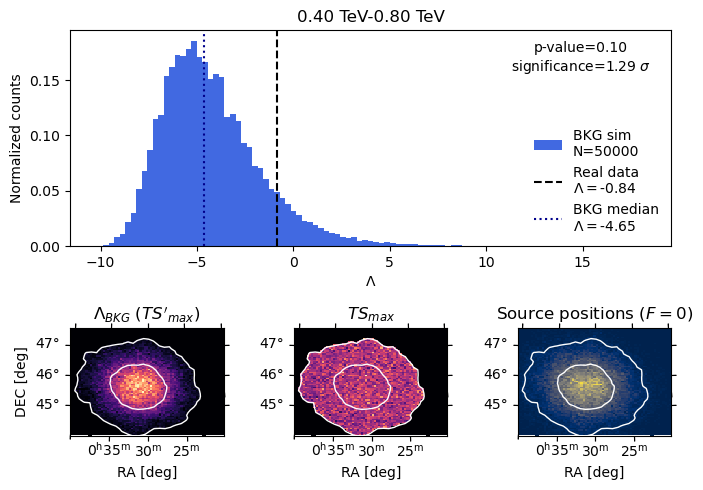

In [23]:
fig = plt.figure(figsize=(7, 5))
gs = GridSpec(2, 3, figure=fig, height_ratios=[2, 1])
axt = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0], projection=geom.wcs)
ax2 = fig.add_subplot(gs[1, 1], projection=geom.wcs)
ax3 = fig.add_subplot(gs[1, 2], projection=geom.wcs)

axt.hist(lambda_bkg, bins_lambda, color="royalblue", 
         density=True, histtype="stepfilled", label=f"BKG sim\nN={len(lambda_bkg)}")
axt.text(
    0.85, 0.87, f"p-value={p_value:.2f}\nsignificance={significance:.2f} $\sigma$",
    ha="center", va="center", transform=axt.transAxes
)
axt.axvline(lambda_real, color="k", ls="--", label=f"Real data\n$\Lambda=${lambda_real:.2f}")
axt.axvline(lambda_bkg_m, color="darkblue", ls=":", label=f"BKG median\n$\Lambda=${lambda_bkg_m:.2f}")

for ax, cmap, mapa, lab in zip(
    [ax1, ax2, ax3], ["magma", "magma", "cividis"],
    [map_lambda_bkg, map_ts_bkg, map_source_sim], 
    ["$\Lambda$", "$TS_{\text{MAX}}$", "Simulated sources"]
):
    pc = ax.pcolormesh(
        bin_edges_ra, bin_edges_dec, mapa.data, cmap=cmap,
        transform=ax.get_transform("icrs")
    )

    lims = ax.get_xlim(), ax.get_ylim()
    ax.contour(
        data_ligo_2d, levels=threshold_maps, transform=ax.get_transform("icrs"), origin="lower",
        extent=[-180, 180, -90, 90], colors="w", linewidths=1,
    )
    ax.set_xlim(lims[0][0], lims[0][1]); ax.set_ylim(lims[1][0], lims[1][1])


axt.legend(frameon=False, loc=4)
axt.set_xlabel("$\Lambda$"); axt.set_ylabel("Normalized counts")
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("RA [deg]")
ax1.set_ylabel("DEC [deg]"); ax2.set_ylabel(" "); ax3.set_ylabel(" ")
ax1.set_title("$\Lambda_{BKG}$ ($TS'_{max}$)")
ax2.set_title("$TS_{max}$"); ax3.set_title("Source positions $(F=0)$")
axt.set_title(f"{energy_edges[0]:.2f}-{energy_edges[1]:.2f}")
fig.tight_layout()

plt.show()

# Sending jobs for flux simulations

In [18]:
n_sim_f = 10500
fluxes = np.logspace(-13, -10, 200)
compute_uls_f = 0

for flux in fluxes:
    fname_results_f  = f"{source_name}_{type_obs}_E_{e_min.value}_{e_max.value}"
    fname_results_f += f"_N_{n_sim_f}_f_{flux}_{'extended' if bool(compute_uls_f) else ''}.npz"
    path_results_f   = os.path.join("data", "results", fname_results_f)
    
    # First we check if the results file already exists
    if os.path.exists(path_results_f):
        print(f"Flux Amplitude: {flux:.2e} - Results already exist")
        continue
        
    _command_ = f"python utils.py {n_sim_f} {flux} {path_pkl} {path_results_f} {compute_uls_f}"    
    
    str_output = f"-o ./data/slurm_output/job_simulate_{type_obs}_F{flux:.4e}_N{n_sim_f}.out"
    slurm_command = f"sbatch -p short --mem=20000 -J simulate_source {str_output} --wrap='{_command_}'"

    subprocess.run(slurm_command, shell=True, check=True)

Submitted batch job 50493619
Submitted batch job 50493620
Submitted batch job 50493621
Submitted batch job 50493622
Submitted batch job 50493623
Submitted batch job 50493624
Submitted batch job 50493625
Submitted batch job 50493626
Submitted batch job 50493627
Submitted batch job 50493628
Submitted batch job 50493629
Submitted batch job 50493630
Submitted batch job 50493631
Submitted batch job 50493632
Submitted batch job 50493633
Submitted batch job 50493634
Submitted batch job 50493635
Submitted batch job 50493636
Submitted batch job 50493637
Submitted batch job 50493638
Submitted batch job 50493639
Submitted batch job 50493640
Submitted batch job 50493641
Submitted batch job 50493642
Submitted batch job 50493643
Submitted batch job 50493644
Submitted batch job 50493645
Submitted batch job 50493646
Submitted batch job 50493647
Submitted batch job 50493648
Submitted batch job 50493649
Submitted batch job 50493650
Submitted batch job 50493651
Submitted batch job 50493652
Submitted batc

In [120]:
!squeue -u juan.jimenez

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON) 


### Reading the result `.npz` files

In [36]:
%%time
cache_file = os.path.join(
    "data", "tmp", f"{source_name}_{type_obs}_E_{e_min.value}_{e_max.value}_N{n_sim_f}_cache.pkl"
)

if os.path.exists(cache_file):
    print(f"Loading cached results...")
    with open(cache_file, "rb") as f:
        (ra_f, dec_f, lambda_f, lambda_ra_f, lambda_dec_f,
         ts_dist_f, ts2_dist_f, tsmax_f, tsmax_ra_f, tsmax_dec_f) = pickle.load(f)
else:
    print("Reading and re-agruping data...")
    ra_f, dec_f, lambda_f, lambda_ra_f, lambda_dec_f = [], [], [], [], []
    ts_dist_f, ts2_dist_f, tsmax_f, tsmax_ra_f, tsmax_dec_f = [], [], [], [], []

    for i, flux in enumerate(fluxes): 
        fname_results_f  = f"{source_name}_{type_obs}_E_{e_min.value}_{e_max.value}"
        fname_results_f += f"_N_{n_sim_f}_f_{flux}_{'extended' if bool(compute_uls_f) else ''}.npz"
        path_results_f   = os.path.join("data", "results", fname_results_f)
        
        print(f"Loading data... {i/len(fluxes)*100:.2f}%") if i % 10 == 0 else None

        data = np.load(path_results_f)
        _lambda_ra_f_, _lambda_dec_f_ = -data["f_ra"], data["f_dec"]

        # check if event is inside masked region
        paths = plt.contour(
            np.rad2deg(ra_grid), np.rad2deg(dec_grid),
            np.flip(data_ligo_2d, axis=1), levels=[threshold_maps[0]]  # 95% threshold
        ).collections[0].get_paths()
        plt.close()

        is_inside = np.array([
            any(p.contains_point((_lambda_ra_f_[j], _lambda_dec_f_[j])) for p in paths)
            for j in range(len(_lambda_ra_f_))
        ])
        
        ra_f.append(_lambda_ra_f_[is_inside])
        dec_f.append(_lambda_dec_f_[is_inside])
        lambda_f.append(data["lambda_data"][is_inside])
        lambda_ra_f.append(data["lambda_ra"][is_inside])
        lambda_dec_f.append(data["lambda_dec"][is_inside])
        tsmax_f.append(data["tsmax"][is_inside])
        tsmax_ra_f.append(data["tsmax_ra"][is_inside])
        tsmax_dec_f.append(data["tsmax_dec"][is_inside])
#         ts_dist_f.append(data["ts_dist"][is_inside])
#         ts2_dist_f.append(data["ts2_dist"][is_inside])

    # Save backup
    with open(cache_file, "wb") as f:
        pickle.dump(
            (ra_f, dec_f, lambda_f, lambda_ra_f, lambda_dec_f,
             ts_dist_f, ts2_dist_f, tsmax_f, tsmax_ra_f, tsmax_dec_f),
            f
        )


Loading cached results...
CPU times: user 83.8 ms, sys: 47 ms, total: 131 ms
Wall time: 125 ms


#### Plotting all the distributions

In [37]:
log_fluxes = np.log10(fluxes)
log_edges_inner = (log_fluxes[1:] + log_fluxes[:-1]) / 2
flux_edges_inner = 10**log_edges_inner

first_edge = 10**(2*log_fluxes[0] - log_edges_inner[0])
last_edge = 10**(2*log_fluxes[-1] - log_edges_inner[-1])

flux_edges = np.concatenate([[first_edge], flux_edges_inner, [last_edge]])

lambda_bins = np.linspace(-12, 80, 200)
lambda_bins_c = (lambda_bins[1:] + lambda_bins[:-1]) / 2

lambda_hist_bkg = np.histogram(lambda_bkg, lambda_bins, density=False)[0]
lambda_hist_f   = np.array([np.histogram(l, lambda_bins, density=False)[0] for l in lambda_f])

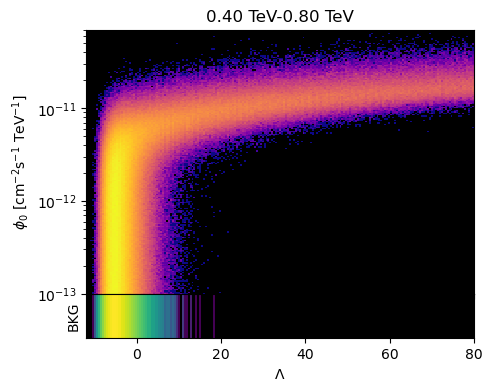

In [38]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 4), gridspec_kw={"height_ratios": [6, 1]}, sharex=True)

pc1 = ax1.pcolormesh(lambda_bins, flux_edges, lambda_hist_f, norm=LogNorm(), cmap="plasma")
pc2 = ax2.pcolormesh(lambda_bins, [0, 1], [lambda_hist_bkg], norm=LogNorm(), cmap="viridis")

for ax in [ax1, ax2]:
    ax.set_facecolor("k")
ax1.set_ylim(1e-13, 7e-11); ax1.set_yscale("log"); ax2.set_yticks([])
ax2.set_ylabel(f"BKG"); ax2.set_xlabel("$\Lambda$")
ax1.set_ylabel("$\phi_0$ [cm${}^{-2}$s${}^{-1}$ TeV${}^{-1}$]")
ax1.set_title(f"{energy_edges[0]:.2f}-{energy_edges[1]:.2f}")
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

## Computing sensitivity + ULs
First we set the confidence level of the limits selection.

In [39]:
cl = 0.95

In [40]:
lambda_f_m = np.array([np.percentile(l, 50) for l in lambda_f])

lambda_f_frac_bkg  = np.array([np.sum(l > lambda_bkg_m) / len(l) for l in lambda_f])
lambda_f_frac_real = np.array([np.sum(l > lambda_real)  / len(l) for l in lambda_f])

x_bkg, y_bkg = np.log10(fluxes), lambda_f_frac_bkg
popt_bkg, pcov_bkg   = curve_fit(
    utils.sigmoid, x_bkg, y_bkg, p0=[max(y_bkg), np.median(x_bkg), 1, min(y_bkg)])
x_real, y_real = np.log10(fluxes), lambda_f_frac_real
popt_real, pcov_real = curve_fit(
    utils.sigmoid, x_real, y_real, p0=[max(y_real), np.median(x_real), 1, min(y_real)])

def find_x_at_y(y_target, params):
    a, x0, k, y0 = params
    func = lambda x: utils.sigmoid(x, a, x0, k, y0) - y_target
    result = root_scalar(func, bracket=[x0 - 10, x0 + 10], method='brentq')
    return result.root if result.converged else np.nan

def find_flux_at_cl(x, y, cl=0.95):
    x, y = np.array(x), np.array(y)
    s = np.argsort(x); x, y = x[s], y[s]
    a = np.where(y >= cl)[0]
    if len(a) == 0: return np.nan
    i = a[0]
    if i == 0: return 10**x[0]
    x1, x2, y1, y2 = x[i-1], x[i], y[i-1], y[i]
    return 10**(x1 + (cl - y1) * (x2 - x1) / (y2 - y1))

# amplitude95_bkg  = 10 ** find_x_at_y(cl, popt_bkg)
# amplitude95_real = 10 ** find_x_at_y(cl, popt_real)

amplitude95_bkg  = find_flux_at_cl(np.log10(fluxes), lambda_f_frac_bkg, cl=cl)
amplitude95_real = find_flux_at_cl(np.log10(fluxes), lambda_f_frac_real, cl=cl)

idx_f_bkg  = np.abs(fluxes - amplitude95_bkg).argmin()
idx_f_real = np.abs(fluxes - amplitude95_real).argmin()

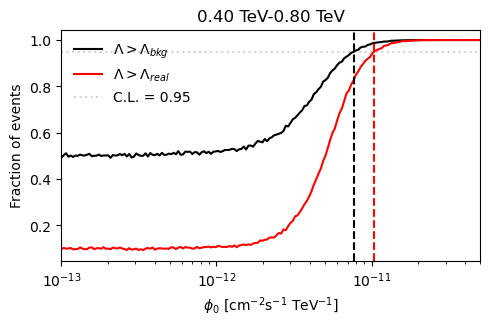

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(5.4, 3))

ax.plot(fluxes, lambda_f_frac_bkg,  color="k", label="$\Lambda>\Lambda_{bkg}$")
ax.plot(fluxes, lambda_f_frac_real, color="r", label="$\Lambda>\Lambda_{real}$")
# plt.plot(10**x_bkg,  utils.sigmoid(x_bkg, *popt_bkg),  color="k", ls=":")
# plt.plot(10**x_real, utils.sigmoid(x_bkg, *popt_real), color="r", ls=":")

ax.axvline(amplitude95_bkg, color="k", ls="--")
ax.axvline(amplitude95_real, color="r", ls="--")
ax.axhline(cl, ls=":", color="lightgray", zorder=-2, label=f"C.L. = {cl}")
ax.legend(frameon=False)

ax.set_xlabel("$\phi_0$ [cm${}^{-2}$s${}^{-1}$ TeV${}^{-1}$]")
ax.set_ylabel("Fraction of events")
ax.set_title(f"{energy_edges[0]:.2f}-{energy_edges[1]:.2f}")
ax.set_xlim(1e-13, 5e-11)
ax.set_xscale("log")
plt.show()

In [42]:
pwl_bkg = PowerLawSpectralModel(
    amplitude=amplitude95_bkg * u.Unit("TeV-1 s-1 cm-2"), index=2
)
flux_bkg = pwl_bkg.integral(*energy_edges)
flux_diff_bkg = pwl_bkg.energy_flux(*energy_edges).to(u.erg/(u.s*u.cm**2))
pwl_real = PowerLawSpectralModel(
    amplitude=amplitude95_real * u.Unit("TeV-1 s-1 cm-2"), index=2
)
flux_real = pwl_real.integral(*energy_edges) 
flux_diff_real = pwl_real.energy_flux(*energy_edges).to(u.erg/(u.s*u.cm**2))

print(f"Signifcance of observations: {significance:.2f}\u03C3\n")
col_sens, col_ul, final_f_ul = ("33", "32", flux_real) if (significance >= 0.0) else ("32", "31", flux_bkg)
print(f"\033[{col_sens}mSensitivity of observations:\n - phi0 = {amplitude95_bkg:.2e} TeV-1 s-1 cm-2\033[0m")
print(f"\033[{col_sens}m - Flux = {flux_bkg:.2e}\033[0m")
print(f"\033[{col_sens}m - Differential Flux = {flux_diff_bkg:.2e}\033[0m")

print(f"\033[{col_ul}m\nUpperLimits of observations:\n - phi0 = {amplitude95_real:.2e} TeV-1 s-1 cm-2\033[0m")
print(f"\033[{col_ul}m - Flux = {flux_real:.2e}\033[0m")
print(f"\033[{col_ul}m - Differential Flux = {flux_diff_real:.2e}\033[0m")

print(f"\nRelative differences with sky-map ULs:")
print(f" - With Full Map: {(final_f_ul.value-np.nanmax(flux_uls))/np.nanmax(flux_uls)*100:+.1f}%")
print(f" - With 95% region: {(final_f_ul.value-np.nanmax(flux_uls_95))/np.nanmax(flux_uls_95)*100:+.1f}%")

Signifcance of observations: 1.29σ

Sensitivity of observations:
 - phi0 = 7.71e-12 TeV-1 s-1 cm-2
 - Flux = 9.64e-12 1 / (s cm2)
 - Differential Flux = 8.57e-12 erg / (s cm2)

UpperLimits of observations:
 - phi0 = 1.04e-11 TeV-1 s-1 cm-2
 - Flux = 1.30e-11 1 / (s cm2)
 - Differential Flux = 1.15e-11 erg / (s cm2)

Relative differences with sky-map ULs:
 - With Full Map: -65.4%
 - With 95% region: +2.9%


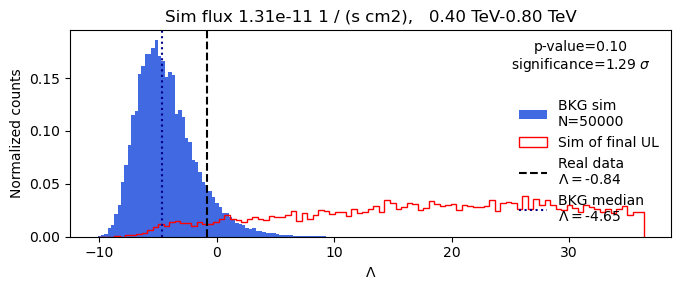

In [43]:
fig, axt = plt.subplots(1, 1, figsize=(7, 3))

axt.hist(lambda_bkg, bins_lambda, color="royalblue", 
         density=True, histtype="stepfilled", label=f"BKG sim\nN={len(lambda_bkg)}")
axt.hist(lambda_f[idx_f_bkg if significance < 0 else idx_f_real], 
         bins_lambda_ext, color="r", density=True, histtype="step", label=f"Sim of final UL")

axt.text(
    0.85, 0.87, f"p-value={p_value:.2f}\nsignificance={significance:.2f} $\sigma$",
    ha="center", va="center", transform=axt.transAxes
)
axt.axvline(lambda_real, color="k", ls="--", label=f"Real data\n$\Lambda=${lambda_real:.2f}")
axt.axvline(lambda_bkg_m, color="darkblue", ls=":", label=f"BKG median\n$\Lambda=${lambda_bkg_m:.2f}")

axt.legend(frameon=False, loc=4)
axt.set_xlabel("$\Lambda$"); axt.set_ylabel("Normalized counts")

pwl_sim = PowerLawSpectralModel(
    amplitude=fluxes[idx_f_bkg if significance < 0 else idx_f_real] * u.Unit("TeV-1 s-1 cm-2"), index=2
)
flux_sim = pwl_sim.integral(*energy_edges)

axt.set_title(f"Sim flux {flux_sim:.2e},   {energy_edges[0]:.2f}-{energy_edges[1]:.2f}")
fig.tight_layout()

plt.show()

### Showing the ULs in front of the real distributions

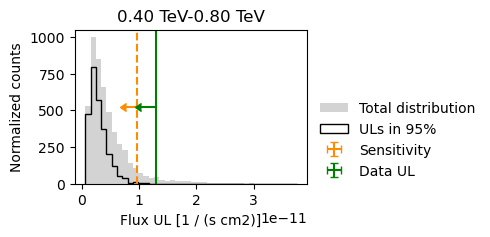

In [44]:
fig, ax = plt.subplots(figsize=(3, 2))

h = ax.hist(flux_uls, 40, histtype="stepfilled", color="lightgray", label="Total distribution")
ax.hist(flux_uls_95, h[1], histtype="step", color="k", label="ULs in 95%")

if significance >= 0.0:
    col_sens, col_ul = "darkorange", "green"
    lab_sens, lab_ul = "Sensitivity", "Data UL"
    ls_sens,  ls_ul  = "--", "-"
else:
    col_sens, col_ul = "green", "darkorange"
    lab_sens, lab_ul = "Data UL", "Overestimated UL"
    ls_sens,  ls_ul  = "-", "--"

ax.axvline(flux_bkg.value, ls=ls_sens, color=col_sens)
ax.errorbar(flux_bkg.value, np.diff(ax.get_ylim())[0]/2, yerr=0, 
    xerr=flux_bkg.value*0.2, xuplims=True, ls="", color=col_sens, label=lab_sens)

ax.axvline(flux_real.value, ls=ls_ul, color=col_ul)
ax.errorbar(flux_real.value, np.diff(ax.get_ylim())[0]/2, yerr=0, 
    xerr=flux_real.value*0.2, xuplims=True, ls="", color=col_ul, label=lab_ul)

#         ax.axvline(flux_ul.value, ls="-", color="crimson")
#     ax.errorbar(flux_ul.value, np.diff(ax.get_ylim())[0]/2, yerr=0, 
#         xerr=flux_ul.value*0.4, xuplims=True, ls="", color="crimson", label="Global UL")
    
    
ax.set_xlabel("Flux UL [1 / (s cm2)]"); ax.set_ylabel("Normalized counts")
ax.set_title(f"{energy_edges[0]:.2f}-{energy_edges[1]:.2f}")
ax.legend(frameon=False, loc=(1.03, 0))

plt.show()

### Showing UL distributions in the simulations

In [45]:
if compute_uls:
    
    fig, ax = plt.subplots(figsize=(5, 3))
    
    ax.hist(ulmax_bkg, 25, density=True, 
            histtype="stepfilled", color="royalblue", label="Maximum UL in 95%", zorder=-5)
    
#     ax.hist(flux_uls, 50, density=True, histtype="step", ls=":", color="k", label="Real Data", zorder=10)
    ax.hist(flux_uls_95, 40, density=True, histtype="step", color="k", label="Real Data 95%", zorder=10)
    
    for data in ul_dist:
        data_95 = np.where(mask_threshold_95, data, np.nan).ravel()
        ax.hist(data_95, 40, density=True, histtype="step", color="0.5", alpha=0.2, zorder=0)
    
    flux_ul = flux_bkg if significance < 0 else flux_real
    ax.axvline(flux_ul.value, ls="-", color="crimson")
    ax.errorbar(flux_ul.value, np.diff(ax.get_ylim())[0]/2, yerr=0, 
        xerr=flux_ul.value*0.4, xuplims=True, ls="", color="crimson", label="Global UL")
    ax.plot([], [], color="gray", ls="-", marker="", 
            label="Simulation\ndistributions 95%")

    
    ax.set_title(f"{energy_edges[0]:.2f}-{energy_edges[1]:.2f}")
    
    ax.legend(loc=(1.03, 0), frameon=False)
    ax.set_xlabel("Flux UL [1 / (s cm2)]"); ax.set_ylabel("Normalized counts")
    
    plt.show()

In [46]:
if compute_uls:
    
    fig, ax = plt.subplots(figsize=(5, 3))
    
    ax.hist(lambda_bkg, 30, density=True, 
            histtype="stepfilled", color="r", label="$\Lambda$ (max TS')", zorder=-5)
    ts2_masked = np.where(mask_threshold_95, ts2, np.nan).ravel()
    ax.hist(ts2_masked, 30, density=True, histtype="step", color="k", label="Real Data", zorder=10)
    for data in ts2_dist:
        data = np.where(mask_threshold_95, data, np.nan).ravel()
        ax.hist(data, 30, density=True, histtype="step", color="0.5", alpha=0.2, zorder=0)
    
    ax.set_title(f"{energy_edges[0]:.2f}-{energy_edges[1]:.2f}")
    ax.plot([], [], color="0.8", label="Simulated data")
    
    plt.legend(loc=(1.03, 0), frameon=False)
    ax.set_xlabel("TS'"); ax.set_ylabel("Normalized counts")
    ax.set_title(f"{energy_edges[0]:.2f}-{energy_edges[1]:.2f}")
    plt.show()